In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from stockapp import models as stkmd
from dataapp import models as dtamd
from dataapp import tasks as dtatks
from dataapp import libs as dtalibs
from stockapp import tasks as stktks
from stockapp import libs as stklibs
import utility as uty
import itertools as itt
import multiprocessing as mp
from django.db import connection,connections
from django.db import reset_queries
import time 
import pandas as pd
import numpy as np
import inspect
import imp
import datetime
import utility.models as utmd
import stockapp.libs as stklib
from utility import codemanager as cdmng

from django.contrib.auth.models import AnonymousUser

In [34]:
code1="""
import pandas as pd
a=2
class test(object):
    def func(self,x):
        return x+3
def func3(x):
    return x+4
"""

code2="""
import pandas as pd
a=3
class test(object):
    def func(self,x):
        return x+3
def func3(x):
     7
    return x+4
"""

# import compiler
# mod = compiler.parse(code)
# mod.node.nodes[1].code

# exec(code)



from types import ModuleType
compiled1 = compile(code1, '', 'exec')
module1 = ModuleType("testmodule1")
exec(compiled1, module1.__dict__)
print module1.func3(7)
print module1.a

compiled2 = compile(code2, '', 'exec')
module2 = ModuleType("testmodule2")
exec(compiled2, module2.__dict__)
print module2.func3(7)
print module2.a

11
2


IndentationError: unindent does not match any outer indentation level (line 9)

In [10]:
T=dtatks.test()
T.run()

In [13]:
r=dtatks.func.delay(4)
r.get()

7

In [18]:
indcode=stkmd.IndexCode(Code='1',File='2')
indcode.save()

In [12]:
indcode=IndexCode.objects.all()[0]
indcode.File=indcode.getfilepath()
indcode.save()

In [15]:
indcode=stkmd.IndexCode.objects.all()[0]
print indcode.File

indclass=stkmd.IndexClass.objects.filter(IndexCode=indcode)
indicies=stkmd.Index.objects.filter(IndexClass__in=indclass)

print indclass
print indicies

/home/venkat/Documents/repos/trade_analytics/trade_analytics/stockapp/IndexCodes/AnonymousUser.py
<QuerySet [<IndexClass: 2, AveragePrice>]>
<QuerySet [<Index: SMA20, SMA greater than 20, <type 'int'>, 2, AveragePrice>]>


In [7]:
stkmd.IndexComputeCode.objects.all()

<QuerySet [<IndexComputeCode: None,  ... , des/AnonymousUser.py>]>

In [8]:
stkmd.IndexComputeClass.objects.all()

<QuerySet [<IndexComputeClass: 2, AveragePrice>]>

<QuerySet [<Index: VolAvgClose, VolAvgClose, <class 'pandas.core.frame.DataFrame'>, 2, AveragePrice>, <Index: AvgClose, AverageClose, <class 'pandas.core.frame.DataFrame'>, 2, AveragePrice>]>

In [35]:
stklib.SyncIndices_files2db()

In [36]:
print stkmd.IndexComputeCode.objects.all()
print stkmd.IndexComputeClass.objects.all()
print stkmd.Index.objects.all()

<QuerySet [<IndexComputeCode: None,  ... , des/AnonymousUser.py>]>
<QuerySet [<IndexComputeClass: 2, AveragePrice>]>
<QuerySet [<Index: VolAvgClose, VolAvgClose, <class 'pandas.core.frame.DataFrame'>, 2, AveragePrice>, <Index: AvgClose, AverageClose, <class 'pandas.core.frame.DataFrame'>, 2, AveragePrice>]>


In [33]:
stkmd.IndexComputeClass.objects.all()[0].delete()

(4,
 {u'stockapp.Index': 2,
  u'stockapp.IndexComputeClass': 1,
  u'stockapp.StockGroupIndex': 1})

In [13]:
indclass=stkmd.IndexComputeClass.objects.all()[0]
indclass

<IndexComputeClass: 2, AveragePrice>

In [17]:
indcode=stkmd.IndexComputeCode.objects.all()[0]
print indcode.id
indcode

2


<IndexComputeCode: None,  ... , des/AnonymousUser.py>

In [18]:
stkmd.Index.objects.filter(IndexComputeClass__IndexComputeCode__id=indcode.id)

<QuerySet [<Index: VolAvgClose, VolAvgClose, <class 'pandas.core.frame.DataFrame'>, 2, AveragePrice>, <Index: AvgClose, AverageClose, <class 'pandas.core.frame.DataFrame'>, 2, AveragePrice>]>

In [7]:
stkmd.Stockmeta.objects.update(Status='Active',Download=True,Derived=False,ComputeFeature=True)


7939

In [9]:
stkmd.StockGroup.objects.all()

<QuerySet [<StockGroup: Sector: Utilities>, <StockGroup: Sector: Basic Materials>, <StockGroup: Sector: Healthcare>, <StockGroup: Sector: Consumer Goods>, <StockGroup: Sector: Technology>, <StockGroup: Sector: Services>, <StockGroup: Sector: Financial>, <StockGroup: Sector: Conglomerates>, <StockGroup: Sector: Industrial Goods>, <StockGroup: Industry: Application Software>, <StockGroup: Industry: Gold>, <StockGroup: Industry: Investment Brokerage - National>, <StockGroup: Industry: Specialty Retail  Other>, <StockGroup: Industry: Aerospace/Defense - Major Diversified>, <StockGroup: Industry: Major Integrated Oil & Gas>, <StockGroup: Industry: Research Services>, <StockGroup: Industry: Processed &amp; Packaged Goods>, <StockGroup: Industry: Sporting Goods Stores>, <StockGroup: Industry: Tobacco Products  Other>, <StockGroup: Industry: Appliances>, '...(remaining elements truncated)...']>

In [28]:
stkgrp=stkmd.StockGroup.objects.get(GroupName='Sector: Utilities')
grpstks_ids=stkgrp.Symbol.all().values_list('id',flat=True)
grpstks_ids
# df=dtalibs.GetStockData(grpstks_ids,pd.datetime(2002,1,1).date(),pd.datetime.today().date(),'concat')

<StockMetaQuerySet [5, 45, 87, 181, 228, 287, 449, 475, 535, 581, 626, 666, 722, 752, 818, 942, 983, 1220, 1230, 1305, '...(remaining elements truncated)...']>

In [30]:
index=stkmd.Index.objects.all()[0]
stklibs.addIndex("UTIAvg",stkgrp,index,Sector='Utilities',Industry=None,User=None)

{'status': 'Success', 'what': 'Symbol UTIAvg added to database'}

In [37]:
stkmd.StockGroupIndex.objects.all()

<QuerySet []>

In [60]:
dg

,Close,High,Low,Open,Symbol,Volume
Date,,,,,,
2002-01-02,11.77,11.85,11.30,11.60,CWCO,21200
2002-01-02,22.72,22.84,22.48,22.60,WTR,300700
2002-01-02,23.51,23.51,22.36,23.10,NI,2544200
2002-01-02,42.43,42.45,41.07,41.95,PNW,447500
2002-01-02,22.10,22.37,21.90,22.37,APU,78900
2002-01-02,48.48,48.60,47.13,48.30,EXC,2353800
2002-01-02,18.70,18.70,17.54,18.35,UNS,170000
2002-01-02,8.19,8.20,7.89,8.19,CDZI,1200
2002-01-02,29.65,29.74,29.35,29.50,CTWS,4700


In [46]:
dg=dtalibs.StockDataFrame_sanitize(df,standardize=True)

In [61]:
dg[['Close','Open','High','Low','Volume']].groupby(by=dg.index).agg('mean')
    

,Close,Open,High,Low,Volume
Date,,,,,
2002-01-02,23.085000,22.926000,23.174000,22.432000,592440
2002-01-03,23.109000,23.037000,23.271000,22.804000,418980
2002-01-04,23.211000,23.106000,23.394000,22.805000,512680
2002-01-07,23.125000,23.233000,23.386000,22.964000,438170
2002-01-08,23.077000,23.145000,23.303000,22.858000,479400
2002-01-09,22.882000,23.023000,23.273000,22.729000,607210
2002-01-10,23.055000,22.887000,23.205000,22.741000,452410
2002-01-11,23.002000,23.119000,23.256000,22.838000,319310
2002-01-14,22.919000,23.004000,23.272000,22.605000,467860


In [62]:
dd=pd.DataFrame()
for date,ds in dg[['Close','Open','High','Low','Volume']].groupby(by=dg.index):
    sumvol=ds['Volume'].sum()
    volfrac=ds['Volume']/sumvol
    dp=pd.DataFrame({'Close':(ds['Close']*volfrac).sum(),
                  'Open': (ds['Open']*volfrac).sum(),
                  'High': (ds['High']*volfrac).sum(),
                  'Low': (ds['Low']*volfrac).sum(),
                  'Volume': ds['Volume'].mean()},index=[date])
    dd=pd.concat([dd,dp])
dd

,Close,High,Low,Open,Volume
2002-01-02,34.615210,34.674511,33.432147,34.318101,5.924400e+05
2002-01-03,36.710751,36.850533,36.240270,36.454826,4.189800e+05
2002-01-04,37.936434,38.297323,37.507127,37.840242,5.126800e+05
2002-01-07,37.210165,37.395323,36.899144,37.358630,4.381700e+05
2002-01-08,36.839830,37.343791,36.632210,37.250308,4.794000e+05
2002-01-09,35.372777,36.107808,35.244784,35.924798,6.072100e+05
2002-01-10,36.895265,36.963875,36.211270,36.371124,4.524100e+05
2002-01-11,37.546087,38.005315,37.393281,37.806051,3.193100e+05
2002-01-14,35.953368,36.401308,35.365600,35.641586,4.678600e+05
2002-01-15,33.383845,33.852527,33.129010,33.453278,5.618500e+05


In [40]:
indcode=stkmd.IndexCode.objects.all()[0]
indclass=stkmd.IndexClass(IndexCode=IndexCode.objects.all()[0],ClassName=d['classname'], ClassDescription=d['description'] )

indclass.save()

In [43]:
stkmd.IndexClass.objects.all().delete()
stkmd.Index.objects.all().delete()

(1,
 {u'stockapp.Index': 0,
  u'stockapp.IndexClass': 1,
  u'stockapp.StockGroup_IndexClasses': 0})

In [45]:
print stkmd.IndexClass.objects.all()
print stkmd.Index.objects.all()

<QuerySet []>
<QuerySet []>


In [54]:
a=eval('3')

In [55]:
a

3

In [57]:
def func(x):
    return str(x)
ss='func'

F=eval(ss)
F(3)

'3'

In [67]:
f=lambda x: str(x)
ss='lambda x: str(x)'
F=eval(ss)
F(3)

'3'

In [65]:
ss

'<function <lambda> at 0x7f7adbc3f7d0>'

In [7]:
semaphore = mp.Semaphore(1)

def func(x,*args,**kwargs):
    time.sleep(1)
    with kwargs['semaphore']:
        print x
        time.sleep(2)
P=[]
for i in range(10):
    P.append(mp.Process(target=func,args=(i,),kwargs={'semaphore':semaphore}))

for p in P:
    p.start()
    
for p in P:
    p.join()

0
1
2
3
4
6
7
5
8
9


print dtamd.Stockprice.objects.all().delete()
stkmd.Stockmeta.objects.all().update(LastPriceUpdate=None,Lastdate=None,Startdate=None)


In [ ]:
tt=(1,2)
tt=tt+(3,)
tt

In [ ]:
print stkmd.Stockmeta.objects.filter(Symbol='AAPL').values()
stk=stkmd.Stockmeta.objects.get(Symbol='AAPL')
print stk
print dtamd.Stockprice.objects.filter(Symbol='AAPL').count()
dtatks.UpdatePriceData([stk.id],inputtype='id')

In [ ]:
stk=stkmd.Stockmeta.objects.get(Symbol='AAPL')
stocksiter=iter([[stk.id,stk.id],[stk.id]])
# for ss in stocksiter:
#     print tuple(ss)
# print 
computeargs_iter=itt.imap(lambda x: itt.izip([x],['id'] ) , stocksiter)
for ss in computeargs_iter:
    print list( ss )

In [ ]:
for ss in zip([(1,2),(3,4)],itt.repeat('id')):
    print ss

In [ ]:
# run in parallel
stk=stkmd.Stockmeta.objects.get(Symbol='AAPL')
stocksiter=iter([[stk.id,stk.id],[stk.id]])
computeargs_iter=itt.izip(stocksiter,itt.repeat('id') ) 
      
PllCmpt=uty.ParallelCompute( computeargs_iter, dtatks.UpdatePriceData )
PllCmpt.parallelrun()

In [8]:
dtatks.RunDataDownload()

error downloading  ARSD  for input dates  2002-01-01 2017-05-01
error downloading  CMGE  for input dates  2002-01-01 2017-05-01
error downloading  IG  for input dates  2002-01-01 2017-05-01
error downloading  ICGE  for input dates  2002-01-01 2017-05-01
error downloading  LEAF  for input dates  2002-01-01 2017-05-01
error downloading  PCP  for input dates  2002-01-01 2017-05-01
error downloading  SZYM  for input dates  2002-01-01 2017-05-01
error downloading  BEE  for input dates  2002-01-01 2017-05-01
error downloading  TLM  for input dates  2002-01-01 2017-05-01
error downloading  TEG  for input dates  2002-01-01 2017-05-01
error downloading  CEP  for input dates  2002-01-01 2017-05-01
error downloading  HNSN  for input dates  2002-01-01 2017-05-01
error downloading  SVLC  for input dates  2002-01-01 2017-05-01
error downloading  GSJK  for input dates  2002-01-01 2017-05-01
error downloading  VCLK  for input dates  2002-01-01 2017-05-01
error downloading  GVT  for input dates  2002-0

Process Process-126:
Process Process-150:
Process Process-151:
Process Process-154:
Process Process-157:
Process Process-133:
Process Process-155:
Process Process-134:
Process Process-153:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-141:
Traceback (most recent call last):
Process Process-127:
Traceback (most recent call last):
Process Process-139:
Process Process-131:
Process Process-128:
Process Process-146:
Process Process-156:
Process Process-88:
KeyboardInterrupt
Process Process-158:


Process Process-160:
Process Process-130:
Process Process-129:
Process Process-135:
Process Process-143:
Process Process-159:
Process Process-116:
Process Process-147:
Process Process-124:
Process Process-145:
Process Process-97:
Process Process-132:
Process Process-121:
Process Process-86:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-138:
Process Process-125:
Process Process-142:
Process Process-148:
Process Process-122:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process Process-120:
Process Process-117:
Process Process-118:
Process Process-115:
Process Process-152:
Process Process-149:
Process Process-144:
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call las

    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  Fi

KeyboardInterrupt: 

  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr

  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    return self._get_current_object()(*a, **kw)
    self.run()
    return self._get_current_object()(*a, **kw)
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self.run()
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/usr/local/lib/python

  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    return self._get_current_object()(*a, **kw)
    return self._get_current_object()(*a, **kw)
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    return self._get_current_object()(*a, **kw)
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages

  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    return self._get_current_object()(*a, **kw)
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
    kwargs['lock'].acquire()
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    return self._get_current_object()(*a, **kw)
    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
    self._target(*self._args, **self._kwargs)
    return self._get_current_object()(*a, **kw)
    return self._get_current_object()(*a, **kw)
    return self.run(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
    return self.run(*args, **kwargs)
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "/u

KeyboardInterrupt
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    return self._get_current_object()(*a, **kw)
    kwargs['lock'].acquire()
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
    return self.run(*args, **kwargs)
    return self._get_current_object()(*a, **kw)
    kwargs['lock'].acquire()
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    return self.run(*args, **kwargs)
    return self.run(*args, **kwargs)
    return self.run(*args, **kwargs)
    return self._get_current_object()(*a, **kw)
KeyboardInterrupt
    kwargs['lock'].acquire()
    return

    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)


  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__


  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    return self.run(*args, **kwargs)
    return self.run(*args, **kwargs)
    return self._get_current_object()(*a, **kw)
    return self.run(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py", line 1310, in __getitem__
    return self.run(*args, **kwargs)
    kwargs['lock'].acquire()


    kwargs['lock'].acquire()
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
KeyboardInterrupt
    kwargs['lock'].acquire()
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    return self.run(*args, **kwargs)
    return self.run(*args, **kwargs)
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    return self.run(*args, **kwargs)


  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
KeyboardInterrupt
    return self.run(*args, **kwargs)
    kwargs['lock'].acquire()
KeyboardInterrupt
    kwargs['lock'].acquire()
    kwargs['lock'].acquire()
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    kwargs['lock'].acquire()
    kwargs['lock'].acquire()
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)
KeyboardInterrupt
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterr

  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
    return self.run(*args, **kwargs)
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    kwargs['lock'].acquire()
    kwargs['lock'].acquire()
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt


    return self.run(*args, **kwargs)
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt


    kwargs['lock'].acquire()
KeyboardInterrupt
    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)
KeyboardInterrupt
    return self._getitem_tuple(key)


    return self._get_current_object()(*a, **kw)


KeyboardInterrupt
KeyboardInterrupt
    return self.run(*args, **kwargs)
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)
    kwargs['lock'].acquire()
KeyboardInterrupt


KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__


  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    self.run()


    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py", line 796, in _getitem_tuple


    kwargs['lock'].acquire()
  File "dataapp/tasks.py", line 76, in UpdatePriceData


  File "dataapp/tasks.py", line 76, in UpdatePriceData


    kwargs['lock'].acquire()
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
    return self.run(*args, **kwargs)
    return self.run(*args, **kwargs)


    return self._get_current_object()(*a, **kw)
    return self.run(*args, **kwargs)
KeyboardInterrupt
    kwargs['lock'].acquire()
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    kwargs['lock'].acquire()
    kwargs['lock'].acquire()
    kwargs['lock'].acquire()


KeyboardInterrupt


  File "dataapp/tasks.py", line 76, in UpdatePriceData
    kwargs['lock'].acquire()
    kwargs['lock'].acquire()


  File "dataapp/tasks.py", line 77, in UpdatePriceData
    return self.run(*args, **kwargs)
KeyboardInterrupt
    kwargs['lock'].acquire()
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__
KeyboardInterrupt
    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)
KeyboardInterrupt
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    kwargs['lock'].acquire()
    kwargs['lock'].acquire()
    return self.run(*args, **kwargs)
    kwargs['lock'].acquire()
KeyboardInterrupt
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run


    kwargs['lock'].acquire()
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
KeyboardInterrupt


  File "dataapp/tasks.py", line 76, in UpdatePriceData


    kwargs['lock'].acquire()
KeyboardInterrupt
    kwargs['lock'].acquire()
    return self._getitem_lowerdim(tup)
    kwargs['lock'].acquire()
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    kwargs['lock'].acquire()
KeyboardInterrupt
    kwargs['lock'].acquire()
    kwargs['lock'].acquire()


KeyboardInterrupt
    kwargs['lock'].acquire()


KeyboardInterrupt
    kwargs['lock'].acquire()
KeyboardInterrupt
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt


KeyboardInterrupt


    kwargs['lock'].acquire()
KeyboardInterrupt
    self._target(*self._args, **self._kwargs)
    return self._get_current_object()(*a, **kw)
KeyboardInterrupt
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
    dtamd.Stockprice.objects.bulk_create(objs)
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    kwargs['lock'].acquire()


KeyboardInterrupt
    return self.run(*args, **kwargs)


    kwargs['lock'].acquire()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py", line 922, in _getitem_lowerdim
KeyboardInterrupt


    kwargs['lock'].acquire()
KeyboardInterrupt


    kwargs['lock'].acquire()
    kwargs['lock'].acquire()
  File "/usr/local/lib/python2.7/dist-packages/django/db/models/manager.py", line 85, in manager_method
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
KeyboardInterrupt
KeyboardInterrupt
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
KeyboardInterrupt
    kwargs['lock'].acquire()
    return getattr(self.get_queryset(), name)(*args, **kwargs)
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/django/db/models/query.py", line 442, in bulk_create
KeyboardInterrupt
KeyboardInterrupt
    kwargs['lock'].acquire()
KeyboardInterrupt
KeyboardInterrupt
    section = self._getitem_axis(key, axis=i)


    kwargs['lock'].acquire()
KeyboardInterrupt


KeyboardInterrupt


    ids = self._batched_insert(objs_without_pk, fields, batch_size)
  File "/usr/local/lib/python2.7/dist-packages/celery/local.py", line 191, in __call__


  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py", line 1483, in _getitem_axis


    return self.run(*args, **kwargs)
KeyboardInterrupt
    return self.run(*args, **kwargs)


    kwargs['lock'].acquire()


    return self._get_label(key, axis=axis)
KeyboardInterrupt


  File "/usr/local/lib/python2.7/dist-packages/django/db/models/query.py", line 1083, in _batched_insert
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py", line 102, in _get_label


  File "dataapp/tasks.py", line 76, in UpdatePriceData
  File "dataapp/tasks.py", line 76, in UpdatePriceData
KeyboardInterrupt
    return self.obj._xs(label, axis=axis)
    kwargs['lock'].acquire()
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py", line 1804, in xs
    return self._get_current_object()(*a, **kw)
    kwargs['lock'].acquire()


KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/celery/app/task.py", line 379, in __call__
    name=self.index[loc], dtype=new_values.dtype)
KeyboardInterrupt
    return self.run(*args, **kwargs)


  File "/usr/local/lib/python2.7/dist-packages/pandas/core/series.py", line 245, in __init__
  File "dataapp/tasks.py", line 76, in UpdatePriceData
    self._insert(item, fields=fields, using=self.db)


  File "/usr/local/lib/python2.7/dist-packages/django/db/models/query.py", line 1060, in _insert


    return query.get_compiler(using=using).execute_sql(return_id)


  File "/usr/local/lib/python2.7/dist-packages/django/db/models/sql/compiler.py", line 1098, in execute_sql
    kwargs['lock'].acquire()
    data = SingleBlockManager(data, index, fastpath=True)
    for sql, params in self.as_sql():
KeyboardInterrupt
  File "/usr/local/lib/python2.7/dist-packages/pandas/core/internals.py", line 4072, in __init__
    self.blocks = [block]
KeyboardInterrupt


  File "/usr/local/lib/python2.7/dist-packages/django/db/models/sql/compiler.py", line 1051, in as_sql


    for obj in self.query.objs
  File "/usr/local/lib/python2.7/dist-packages/django/db/models/sql/compiler.py", line 990, in prepare_value
    value = field.get_db_prep_save(value, connection=self.connection)


  File "/usr/local/lib/python2.7/dist-packages/django/db/models/fields/__init__.py", line 1600, in get_db_prep_save
    return connection.ops.adapt_decimalfield_value(self.to_python(value), self.max_digits, self.decimal_places)
  File "/usr/local/lib/python2.7/dist-packages/django/db/backends/base/operations.py", line 503, in adapt_decimalfield_value
    return utils.format_number(value, max_digits, decimal_places)
  File "/usr/local/lib/python2.7/dist-packages/django/db/backends/utils.py", line 215, in format_number
    return "{:f}".format(value)
  File "/usr/lib/python2.7/decimal.py", line 3643, in __format__
    def __format__(self, specifier, context=None, _localeconv=None):
KeyboardInterrupt


In [ ]:
stk=stkmd.Stockmeta.objects.get(Symbol='AAPL')
print stk.LastPriceUpdate
print stk.Lastdate
print stk.Startdate

In [ ]:
from dataapp import models as dtamd
stkmd.Stockmeta.objects.get(Symbol='AAPL').values_list()
dtamd.Stockprice.objects.filter(Symbol='AAPL')
dtamd.Stockprice.objects.all().delete()

In [ ]:
dfstockmeta=pd.read_csv('databases/olddata/stockmeta.csv')
dfwatchlist=pd.read_csv('databases/olddata/watchlist.csv')
dfwatchlist_stocks=pd.read_csv('databases/olddata/watchlist_stocks.csv')

In [ ]:
store=pd.HDFStore('databases/olddata/StockData.h5')
store['AAPL']

In [ ]:
for stk in dfstockmeta['Symbol']:
    print stk
    try:
        df=store[stk]
    except:
        continue
    objs=[]
    for ind in df.index:
        objs.append( dtamd.Stockprice(Close=df.loc[ind,'Close'], Open=df.loc[ind,'Open'] ,
                                     High=df.loc[ind,'High'],Low=df.loc[ind,'Low'],
                                     Volume=df.loc[ind,'Volume'],Date=ind,Symbol=stk)  )
    
    dtamd.Stockprice.objects.bulk_create(objs)
  

In [ ]:
ss=stkmd.Stockmeta.objects.all()
S=ss.values('Symbol','Company','Sector','Industry','Status','Labels')
S[0]

In [ ]:
from django.db.models import Count,Max,Min
sp=ss.values('Date').annotate(MaxClose=Max('Close'),MinClose=Min('Close'))
print sp
print
print connections['stockpricedata'].queries
reset_queries()

In [9]:
df=pd.read_sql("""SELECT "dataapp_stockprice"."Date", 
               CAST(MIN("dataapp_stockprice"."Close") AS NUMERIC) AS "MinClose", 
               CAST(MAX("dataapp_stockprice"."Close") AS NUMERIC) AS "MaxClose", 
               CAST(AVG("dataapp_stockprice"."Close") AS NUMERIC) AS "AvgClose" 
               FROM "dataapp_stockprice" 
               WHERE "dataapp_stockprice"."Date" BETWEEN \'2015-01-01\' AND \'2016-01-01\' AND "dataapp_stockprice"."Close" >2 AND "dataapp_stockprice"."Close"<1000
               AND "dataapp_Stockprice"."id" IN (SELECT stockid FROM  )
               GROUP BY "dataapp_stockprice"."Date" 
               ORDER BY "dataapp_stockprice"."Date" ASC LIMIT 21"""
    ,connections['stockpricedata'])

/usr/local/lib/python2.7/dist-packages/django/db/models/base.py:324: RuntimeWarning: Model 'stockapp.stockmeta' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/usr/local/lib/python2.7/dist-packages/django/db/models/base.py:324: RuntimeWarning: Model 'stockapp.indexfunction_user' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/usr/local/lib/python2.7/dist-packages/django/db/models/base.py:324: RuntimeWarning: Model 'stockapp.indexfunction' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/usr/local/lib/python2.7/dist-packages/django/db

DatabaseError: Execution failed on sql 'SELECT "dataapp_stockprice"."Date", 
               CAST(MIN("dataapp_stockprice"."Close") AS NUMERIC) AS "MinClose", 
               CAST(MAX("dataapp_stockprice"."Close") AS NUMERIC) AS "MaxClose", 
               CAST(AVG("dataapp_stockprice"."Close") AS NUMERIC) AS "AvgClose" 
               FROM "dataapp_stockprice" 
               WHERE "dataapp_stockprice"."Date" BETWEEN '2015-01-01' AND '2016-01-01' AND "dataapp_stockprice"."Close" >2 AND "dataapp_stockprice"."Close"<1000
               AND "dataapp_Stockprice"."id" IN (SELECT stockid FROM  )
               GROUP BY "dataapp_stockprice"."Date" 
               ORDER BY "dataapp_stockprice"."Date" ASC LIMIT 21': near ")": syntax error

In [17]:
df=pd.read_sql("""SELECT * from dataapp_stockprice WHERE "dataapp_stockprice"."Date" BETWEEN \'2015-01-01\' AND \'2016-01-01\' AND "dataapp_stockprice"."Close" >2 AND "dataapp_stockprice"."Close"<1000"""
    ,connections['stockpricedata'])

In [19]:
# print df['Symbol'].unique()
df[df['Symbol']=='BSND']

,id,Close,Open,High,Low,Volume,Date,Symbol,Symbol_id
286,1176771,415.0,415.0,415.0,415.0,0.0,2015-01-02,BSND,5005
831,1176772,415.0,415.0,415.0,415.0,0.0,2015-01-05,BSND,5005
1376,1176773,415.0,415.0,415.0,415.0,0.0,2015-01-06,BSND,5005
1922,1176774,415.0,415.0,415.0,415.0,0.0,2015-01-07,BSND,5005
2470,1176775,415.0,415.0,415.0,415.0,0.0,2015-01-08,BSND,5005
3017,1176776,415.0,415.0,415.0,415.0,0.0,2015-01-09,BSND,5005
3564,1176777,415.0,415.0,415.0,415.0,0.0,2015-01-12,BSND,5005
4110,1176778,415.0,415.0,415.0,415.0,0.0,2015-01-13,BSND,5005
4657,1176779,415.0,415.0,415.0,415.0,0.0,2015-01-14,BSND,5005
5204,1176780,415.0,415.0,415.0,415.0,0.0,2015-01-15,BSND,5005


In [ ]:
import pymongo

from pymongo import MongoClient
client = MongoClient()

client = MongoClient('localhost', 27017)
client = MongoClient('mongodb://localhost:27017/')

In [ ]:
db = client['test-database']

collection = db['test-collection']

import datetime
post = {"author": "Mike",
         "text": "My first blog post!",
         "tags": ["mongodb", "python", "pymongo"],
         "date": datetime.datetime.utcnow(),
         "somearray": {"X":[1,2,3],"Y":[4,5,6]} }

posts = db.posts
pp=db.posts.insert_one(post)
pp

In [ ]:
db.collection_names(include_system_collections=True)

In [ ]:
result = db.profiles.create_index([('user_id', pymongo.ASCENDING)],unique=True)
sorted(list(db.profiles.index_information()))


In [ ]:
import numpy as np
db.testing.update_many(
   {  },
   {
     "$set": { "Some": np.nan},
     "$currentDate": { "lastModified": True }
   }
)

In [ ]:
qty="qty"
size="size"
h="h"
w="w"
uom="uom"
status="status"
db.testing.insert_one( 
   { "item": "canvas", qty: 100, size: { h: 28, w: 35.5, uom: "cm" }, status: "A" },
);

db.testing.insert_many( [
   { "item": "canvas", qty: 100, size: { h: 28, w: 35.5, uom: "cm" }, status: "A" },
   { "item": "journal", qty: 25, size: { h: 14, w: 21, uom: "cm" }, status: "A" },
   { "item": "mat", qty: 85, size: { h: 27.9, w: 35.5, uom: "cm" }, status: "A" },
   { "item": "mousepad", qty: 25, size: { h: 19, w: 22.85, uom: "cm" }, status: "P" },
   { "item": "notebook", qty: 50, size: { h: 8.5, w: 11, uom: "in" }, status: "P" },
]);

In [ ]:
for pp in db.testing.find():
    print pp

In [ ]:
pd.read_sql('Select * From dataapp_stockprice',connections['stockpricedata'])

In [ ]:
uty.get_celery_worker_status()

In [ ]:
dtamd.Stockprice.objects.filter(Symbol='AAPL').delete()

In [ ]:
print stkmd.Stockmeta.objects.filter(Symbol='AAPL').values()
stk=stkmd.Stockmeta.objects.get(Symbol='AAPL')
print stk
print dtamd.Stockprice.objects.filter(Symbol='AAPL').count()
dtatks.UpdatePriceData([stk.id],inputtype='id')

In [2]:
import multiprocessing as mp
class Someclass(object):
    def __init__(self,x):
        self.x=x
    def __call__(self,a):
        print a+self.x

p=mp.Process(target=Someclass(3),args=(4,))
p.start()
p.join()

7


In [9]:
from celery import shared_task
class Someclass(object):
    def __init__(self,x):
        self.x=x
    @shared_task
    def __call__(self,a):
        print a+self.x
A=Someclass(3)

@shared_task
def add(x):
    print x+3
r=add.delay(4)
r.collect()

<generator object collect at 0x7f6261934690>

0.524054050446


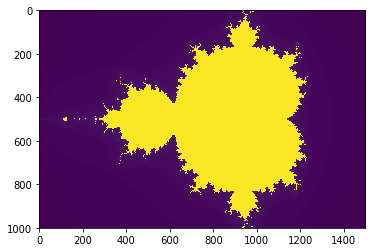

In [18]:

ss="""
from __future__ import print_function, division, absolute_import

from timeit import default_timer as timer
from matplotlib.pylab import imshow, jet, show, ion
import numpy as np

from numba import jit


@jit
def mandel(x, y, max_iters):
    
    #Given the real and imaginary parts of a complex number,
    #determine if it is a candidate for membership in the Mandelbrot
    #set given a fixed number of iterations.
    
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)
imshow(image)
#jet()
#ion()
show()
"""
codeobj = compile(ss, 'fakemodule', 'exec')
exec(codeobj)
    

In [27]:
class A(object):
    a=1
    def __init__(self):
        print( "a")
        
class B(A):
    b=2
    a=3
    def __init__(self):
        print( "b")

b=B()
A.a=7
b.a

b


3

In [ ]:
class IndexFunction(hmd.UserBase):
	IndexCode=models.TextField(help_text='Code to compute the index')
	IndexName=models.CharField(help_text='Name of the index',max_length=50)
	IndexDescription=models.CharField(help_text='Description of the index',max_length=200)

In [30]:
indF=stkmd.IndexFunction(IndexCode=ss,IndexName='test',IndexDescription='just testing ')
indF.save()

In [ ]:
indF=stkmd.IndexFunction(IndexCode=ss,IndexName='test2',IndexDescription='just testing 2 ')
indF.save()

indF=stkmd.IndexFunction(IndexCode=ss,IndexName='test3',IndexDescription='just testing 3 ')
indF.save()


0.472647190094


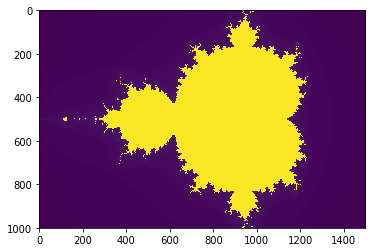

In [32]:

codeobj = compile(indF.IndexCode, 'fakemodule', 'exec')
exec(codeobj)

In [60]:
import inspect as inpt
import stockapp.GroupIndicies.test as tst

inpt.getmembers(tst)
# inpt.getmodulename(tst)
# inpt.ismodule(tst)

[('AnotherFunc', stockapp.GroupIndicies.test.AnotherFunc),
 ('SomeFunc', stockapp.GroupIndicies.test.SomeFunc),
 ('__builtins__',
  {'ArithmeticError': ArithmeticError,
   'AssertionError': AssertionError,
   'AttributeError': AttributeError,
   'BaseException': BaseException,
   'BufferError': BufferError,
   'BytesWarning': BytesWarning,
   'DeprecationWarning': DeprecationWarning,
   'EOFError': EOFError,
   'Ellipsis': Ellipsis,
   'EnvironmentError': EnvironmentError,
   'Exception': Exception,
   'False': False,
   'FloatingPointError': FloatingPointError,
   'FutureWarning': FutureWarning,
   'GeneratorExit': GeneratorExit,
   'IOError': IOError,
   'ImportError': ImportError,
   'ImportWarning': ImportWarning,
   'IndentationError': IndentationError,
   'IndexError': IndexError,
   'KeyError': KeyError,
   'KeyboardInterrupt': KeyboardInterrupt,
   'LookupError': LookupError,
   'MemoryError': MemoryError,
   'NameError': NameError,
   'None': None,
   'NotImplemented': NotImpl

In [71]:
CLS=[]
for pp in inpt.getmembers(tst):
    if inpt.isclass(pp[1]):
        print ( "class ",pp,inpt.getdoc(pp[1]), inpt.getcomments(pp[1]) )
        print (inpt.getsource(pp[1]))
        CLS.append(pp[1])
    if inpt.isfunction(pp[1]):    
        print ( "function ",pp,inpt.getdoc(pp[1]), inpt.getcomments(pp[1]) )
        print (inpt.getsource(pp[1]))
        print (inpt.getargspec(pp[1]))
        break

class  ('AnotherFunc', <class 'stockapp.GroupIndicies.test.AnotherFunc'>) feature class 3 None
class AnotherFunc(compute):
	"""
	feature class 2
	"""
	user='Anonymous'
	def compute(self):
		self.x=3

class  ('SomeFunc', <class 'stockapp.GroupIndicies.test.SomeFunc'>) feature class 1 None
class SomeFunc(compute):
	"""
	feature class 1
	"""
	user='Anonymous'

	def compute(self):
		self.x=3

class  ('compute', <class 'stockapp.GroupIndicies.test.compute'>) None None
class compute(object):
	def __init__(self):
		pass
	def compute(self):
		pass

function  ('func1', <function func1 at 0x7fb151074de8>) test func1 None
def func1(x):
	"""
	test func1
	"""
	return x+1

ArgSpec(args=['x'], varargs=None, keywords=None, defaults=None)


In [70]:
inpt.getargspec(pp[1]).args[0]

'x'

In [75]:
for pp in inpt.getclasstree(CLS):
    print (pp)
    print()

(<type 'object'>, ())

[(<class 'stockapp.GroupIndicies.test.compute'>, (<type 'object'>,)), [(<class 'stockapp.GroupIndicies.test.AnotherFunc'>, (<class 'stockapp.GroupIndicies.test.compute'>,)), (<class 'stockapp.GroupIndicies.test.SomeFunc'>, (<class 'stockapp.GroupIndicies.test.compute'>,))]]



In [80]:
S=inpt.getclasstree(CLS)
S

[(object, ()),
 [(stockapp.GroupIndicies.test.compute, (object,)),
  [(stockapp.GroupIndicies.test.AnotherFunc,
    (stockapp.GroupIndicies.test.compute,)),
   (stockapp.GroupIndicies.test.SomeFunc,
    (stockapp.GroupIndicies.test.compute,))]]]

In [82]:
issubclass(S[1][0][0],S[1][0][1])

True

In [4]:
exec("""
import numpy as np
C=np.zeros((3,3))
""")
C

[autoreload of stockapp.libs failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "stockapp/libs.py", line 31
    else:
       ^
IndentationError: expected an indented block
]
/usr/local/lib/python2.7/dist-packages/django/db/models/base.py:324: RuntimeWarning: Model 'stockapp.stockmeta' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/usr/local/lib/python2.7/dist-packages/django/db/models/base.py:324: RuntimeWarning: Model 'stockapp.computestatus_stockdownload' was already registered. Reloading models is not advised as it can lead to inconsistencies, most notably with related models.
  new_class._meta.apps.register_model(new_class._meta.app_label, new_class)
/usr/local/lib/python2.7/dist-package

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])